In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Input,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
)
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

import pickle
from tensorflow.keras.optimizers import Adam
import gc

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
student_name = "AkhileshNegi" 
reg_number = "221AI008"  

In [4]:
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)
num_classes = 21
batch_size = 64
epochs = 100

train_dir = "/kaggle/input/ucm-data/Images/train"
val_dir = "/kaggle/input/ucm-data/Images/val"
test_dir = "/kaggle/input/ucm-data/Images/test"

In [5]:
def create_cnn_fe_model(input_shape=(256, 256, 3), num_classes=21):
    model = Sequential([
        Input(shape=input_shape),  # Explicitly define input shape

        # First Convolutional Block
        Conv2D(8, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Second Convolutional Block
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(), 
        MaxPooling2D(pool_size=(2, 2)),
        
        # Third Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Fourth Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Flatten and Dense Layers
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.25),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [6]:
# ========================
# Data Generators
# ========================

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

Found 1260 images belonging to 21 classes.
Found 420 images belonging to 21 classes.


## Plotting Normalization Plots

In [7]:
# Build the model
model = create_cnn_fe_model(input_shape=input_shape, num_classes=num_classes)

# Create an intermediate model to extract activations before and after BN
# We pair each Conv2D layer (if followed by BN) with its subsequent BN layer.
layer_names = []  # to keep track of layer pair names
intermediate_outputs = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        # Check if the next layer is BatchNormalization
        if (i + 1) < len(model.layers) and isinstance(model.layers[i+1], tf.keras.layers.BatchNormalization):
            layer_names.append((f"conv_{i}", f"bn_{i+1}"))
            intermediate_outputs.append(layer.output)           # activation before BN
            intermediate_outputs.append(model.layers[i+1].output) # activation after BN

# Build the model that outputs the activations of interest.
debug_model = Model(inputs=model.inputs[0], outputs=intermediate_outputs)

# Create the base output folder for normalized plots.
base_plot_dir = "normalized_plots"
os.makedirs(base_plot_dir, exist_ok=True)

num_epochs = 5
batches_per_epoch = 19  # as specified

In [8]:
# Training loop with custom plotting for each batch
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")
    # Create subfolder for this epoch.
    epoch_folder = os.path.join(base_plot_dir, f"epoch_{epoch}")
    os.makedirs(epoch_folder, exist_ok=True)
    
    batch_index = 0
    # Loop over batches; note that train_generator is an infinite generator.
    while batch_index < batches_per_epoch:
        batch_x, batch_y = next(train_generator)
        batch_x, batch_y= batch_x[:16], batch_y[:16]
        # Train on current batch
        loss, acc = model.train_on_batch(batch_x, batch_y)
        print(f"  Batch {batch_index+1}/{batches_per_epoch} - Loss: {loss:.4f}, Acc: {acc:.4f}")
        
        # Get intermediate activations for the batch.
        activations = debug_model.predict(batch_x)
        num_pairs = len(layer_names)  # number of (conv, bn) pairs
        
        # Create a figure with one row per BN pair and three columns.
        fig, axs = plt.subplots(num_pairs, 3, figsize=(18, 5*num_pairs))
        # If there's only one pair, axs might not be a 2D array.
        if num_pairs == 1:
            axs = np.expand_dims(axs, axis=0)
        
        # For each BN pair, compute and plot the required visualizations.
        for idx in range(num_pairs):
            conv_act = activations[2*idx]       # before BN
            bn_act = activations[2*idx + 1]       # after BN
            
            # Flatten the activations for plotting
            conv_flat = conv_act.flatten()
            bn_flat = bn_act.flatten()
            
            # 1. Histogram (or line plot) showing distribution before and after BN
            ax0 = axs[idx, 0]
            ax0.hist(conv_flat, bins=50, alpha=0.5, label="Before BN")
            ax0.hist(bn_flat, bins=50, alpha=0.5, label="After BN")
            ax0.set_title(f"Activation Distribution\n{layer_names[idx][0]} vs {layer_names[idx][1]}")
            ax0.legend()
            
            # 2. Box plot showing how BN affects activation values
            ax1 = axs[idx, 1]
            ax1.boxplot([conv_flat, bn_flat], labels=["Before BN", "After BN"])
            ax1.set_title("Box Plot")
            
            # 3. Mean and variance plot over training batches
            ax2 = axs[idx, 2]
            means = [np.mean(conv_flat), np.mean(bn_flat)]
            variances = [np.var(conv_flat), np.var(bn_flat)]
            ax2.plot(["Before BN", "After BN"], means, marker='o', label="Mean")
            ax2.plot(["Before BN", "After BN"], variances, marker='o', label="Variance")
            ax2.set_title("Mean and Variance")
            ax2.legend()
        
        # Adjust layout and save the figure.
        plt.tight_layout()
        # Name the file as specified; replace studentname and regnumber accordingly.
        filename = f"batch_{batch_index+1}_{student_name}-{reg_number}-noramlizedgraph.jpeg"
        plot_path = os.path.join(epoch_folder, filename)
        plt.savefig(plot_path)
        plt.close(fig)

        # Delete activations and force garbage collection
        del activations
        gc.collect()
        
        batch_index += 1

print("Training complete and all normalized plots saved.")


Epoch 1/5
  Batch 1/19 - Loss: 3.9131, Acc: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
  Batch 2/19 - Loss: 6.6355, Acc: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
  Batch 3/19 - Loss: 6.6957, Acc: 0.0208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
  Batch 4/19 - Loss: 6.0901, Acc: 0.0312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
  Batch 5/19 - Loss: 6.2406, Acc: 0.0250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Batch 6/19 - Loss: 5.8919, Acc: 0.0312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
  Batch 7/19 - Loss: 5.8158, Acc: 0.0268
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
  Batch 8/19 - Loss: 5.7218, Acc: 0.0391
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
  Batch 9/19 - Loss: 5.7588, Acc: 0.0556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
  Batch 10/19 - Loss: 5.5122, Acc: 0.0625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
  Batch 11/19 - Loss: 5.4865, Acc: 0.0625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
  Batch 12/19 - Loss: 5.3936, Acc: 0.0625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
  Batch 13/19 - Loss: 5.2398, Acc: 0.0

## Model Training

In [9]:
# Build the model
model = create_cnn_fe_model(input_shape=input_shape, num_classes=num_classes)

# Display layer-by-layer parameters once before training
print("Model Parameters (layer-by-layer):")
total_trainable_params = 0

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    trainable_params = sum(w.size for w in weights)
    total_trainable_params += trainable_params

    print(f"Layer {i+1} ({layer.__class__.__name__}):")
    for j, w in enumerate(weights):
        print(f"  Weight {j+1} shape: {w.shape}")
    print(f"  Trainable parameters: {trainable_params}")

print(f"\nTotal trainable parameters in the model: {total_trainable_params}")


Model Parameters (layer-by-layer):
Layer 1 (Conv2D):
  Weight 1 shape: (3, 3, 3, 8)
  Weight 2 shape: (8,)
  Trainable parameters: 224
Layer 2 (BatchNormalization):
  Weight 1 shape: (8,)
  Weight 2 shape: (8,)
  Weight 3 shape: (8,)
  Weight 4 shape: (8,)
  Trainable parameters: 32
Layer 3 (MaxPooling2D):
  Trainable parameters: 0
Layer 4 (Conv2D):
  Weight 1 shape: (3, 3, 8, 16)
  Weight 2 shape: (16,)
  Trainable parameters: 1168
Layer 5 (BatchNormalization):
  Weight 1 shape: (16,)
  Weight 2 shape: (16,)
  Weight 3 shape: (16,)
  Weight 4 shape: (16,)
  Trainable parameters: 64
Layer 6 (MaxPooling2D):
  Trainable parameters: 0
Layer 7 (Conv2D):
  Weight 1 shape: (3, 3, 16, 32)
  Weight 2 shape: (32,)
  Trainable parameters: 4640
Layer 8 (BatchNormalization):
  Weight 1 shape: (32,)
  Weight 2 shape: (32,)
  Weight 3 shape: (32,)
  Weight 4 shape: (32,)
  Trainable parameters: 128
Layer 9 (MaxPooling2D):
  Trainable parameters: 0
Layer 10 (Conv2D):
  Weight 1 shape: (3, 3, 32, 64)


In [10]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# For recording history
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

# Track best validation accuracy
best_val_acc = 0.0
best_model_path = "best_model.keras"

# Measure training time
training_start_time = time.time()

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    steps = 0

    # Wrap the batch generator with tqdm for progress bar
    with tqdm(total=steps_per_epoch, desc=f"Training Epoch {epoch+1}", unit="batch") as pbar:
        for batch_x, batch_y in train_generator:
            steps += 1
            with tf.GradientTape() as tape:
                logits = model(batch_x, training=True)
                loss_value = loss_fn(batch_y, logits)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Compute batch accuracy
            batch_preds = np.argmax(logits.numpy(), axis=1)
            batch_labels = np.argmax(batch_y, axis=1)
            batch_acc = np.mean(batch_preds == batch_labels)

            epoch_loss += loss_value.numpy()
            epoch_accuracy += batch_acc

            # Update tqdm progress bar
            pbar.set_postfix(loss=loss_value.numpy(), acc=batch_acc)
            pbar.update(1)

            if steps >= steps_per_epoch:
                break

    epoch_loss /= steps
    epoch_accuracy /= steps
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_accuracy)

    # ========================
    # Validation Evaluation
    # ========================
    val_loss = 0.0
    val_accuracy = 0.0
    val_steps = 0

    for val_x, val_y in val_generator:
        val_steps += 1
        val_logits = model(val_x, training=False)
        val_loss_value = loss_fn(val_y, val_logits)
        val_preds = np.argmax(val_logits.numpy(), axis=1)
        val_labels = np.argmax(val_y, axis=1)
        val_batch_acc = np.mean(val_preds == val_labels)

        val_loss += val_loss_value.numpy()
        val_accuracy += val_batch_acc

        if val_steps >= validation_steps:
            break

    val_loss /= val_steps
    val_accuracy /= val_steps
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f} | Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        model.save(best_model_path)
        print(f"Best model saved with Validation Accuracy: {best_val_acc:.4f}")

training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

# Save final model
model.save("final_model.keras")
print("Final model saved.")
print("Best Validation Accuracy:", best_val_acc)



Epoch 1/100


Training Epoch 1: 100%|██████████| 19/19 [00:25<00:00,  1.32s/batch, acc=0.266, loss=2.52]


Epoch 1 - Loss: 3.9125, Accuracy: 0.1454 | Val Loss: 3.4549, Val Accuracy: 0.0521
Best model saved with Validation Accuracy: 0.0521

Epoch 2/100


Training Epoch 2: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.328, loss=2.28]


Epoch 2 - Loss: 2.5911, Accuracy: 0.2247 | Val Loss: 6.6247, Val Accuracy: 0.0573
Best model saved with Validation Accuracy: 0.0573

Epoch 3/100


Training Epoch 3: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.406, loss=2.21]


Epoch 3 - Loss: 2.4375, Accuracy: 0.2860 | Val Loss: 8.7868, Val Accuracy: 0.0573

Epoch 4/100


Training Epoch 4: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.297, loss=2.72]


Epoch 4 - Loss: 2.3475, Accuracy: 0.3087 | Val Loss: 11.2661, Val Accuracy: 0.0521

Epoch 5/100


Training Epoch 5: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.344, loss=2.07]


Epoch 5 - Loss: 2.1818, Accuracy: 0.3256 | Val Loss: 12.0010, Val Accuracy: 0.0521

Epoch 6/100


Training Epoch 6: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.312, loss=2.59]


Epoch 6 - Loss: 2.1131, Accuracy: 0.3587 | Val Loss: 14.2343, Val Accuracy: 0.0521

Epoch 7/100


Training Epoch 7: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.453, loss=1.78]


Epoch 7 - Loss: 1.9608, Accuracy: 0.3997 | Val Loss: 19.7901, Val Accuracy: 0.0000

Epoch 8/100


Training Epoch 8: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.328, loss=2.09]


Epoch 8 - Loss: 1.9483, Accuracy: 0.4027 | Val Loss: 18.2836, Val Accuracy: 0.0521

Epoch 9/100


Training Epoch 9: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.562, loss=1.61]


Epoch 9 - Loss: 1.8886, Accuracy: 0.4265 | Val Loss: 14.0273, Val Accuracy: 0.0547

Epoch 10/100


Training Epoch 10: 100%|██████████| 19/19 [00:20<00:00,  1.07s/batch, acc=0.312, loss=2.1]


Epoch 10 - Loss: 1.7704, Accuracy: 0.4392 | Val Loss: 13.7423, Val Accuracy: 0.0677
Best model saved with Validation Accuracy: 0.0677

Epoch 11/100


Training Epoch 11: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.531, loss=1.34]


Epoch 11 - Loss: 1.6912, Accuracy: 0.4759 | Val Loss: 16.8673, Val Accuracy: 0.0599

Epoch 12/100


Training Epoch 12: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.516, loss=1.51]


Epoch 12 - Loss: 1.7255, Accuracy: 0.4407 | Val Loss: 15.1226, Val Accuracy: 0.0521

Epoch 13/100


Training Epoch 13: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.5, loss=1.41]


Epoch 13 - Loss: 1.6000, Accuracy: 0.4859 | Val Loss: 7.3927, Val Accuracy: 0.0645

Epoch 14/100


Training Epoch 14: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.469, loss=1.5]


Epoch 14 - Loss: 1.5336, Accuracy: 0.5046 | Val Loss: 9.1387, Val Accuracy: 0.0078

Epoch 15/100


Training Epoch 15: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.614, loss=1.37]


Epoch 15 - Loss: 1.4779, Accuracy: 0.5282 | Val Loss: 10.7474, Val Accuracy: 0.1120
Best model saved with Validation Accuracy: 0.1120

Epoch 16/100


Training Epoch 16: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.516, loss=1.54]


Epoch 16 - Loss: 1.4444, Accuracy: 0.5493 | Val Loss: 4.6765, Val Accuracy: 0.2170
Best model saved with Validation Accuracy: 0.2170

Epoch 17/100


Training Epoch 17: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.594, loss=1.17]


Epoch 17 - Loss: 1.3573, Accuracy: 0.5625 | Val Loss: 3.0607, Val Accuracy: 0.2746
Best model saved with Validation Accuracy: 0.2746

Epoch 18/100


Training Epoch 18: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.547, loss=1.56]


Epoch 18 - Loss: 1.4034, Accuracy: 0.5464 | Val Loss: 2.8240, Val Accuracy: 0.2934
Best model saved with Validation Accuracy: 0.2934

Epoch 19/100


Training Epoch 19: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.531, loss=1.35]


Epoch 19 - Loss: 1.3618, Accuracy: 0.5513 | Val Loss: 2.3759, Val Accuracy: 0.3411
Best model saved with Validation Accuracy: 0.3411

Epoch 20/100


Training Epoch 20: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.656, loss=1.25]


Epoch 20 - Loss: 1.2758, Accuracy: 0.5916 | Val Loss: 2.2677, Val Accuracy: 0.3383

Epoch 21/100


Training Epoch 21: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.516, loss=1.32]


Epoch 21 - Loss: 1.4011, Accuracy: 0.5563 | Val Loss: 2.7343, Val Accuracy: 0.3044

Epoch 22/100


Training Epoch 22: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.516, loss=1.44]


Epoch 22 - Loss: 1.2820, Accuracy: 0.5751 | Val Loss: 2.1151, Val Accuracy: 0.4688
Best model saved with Validation Accuracy: 0.4688

Epoch 23/100


Training Epoch 23: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.625, loss=1.1]


Epoch 23 - Loss: 1.1914, Accuracy: 0.5887 | Val Loss: 1.6068, Val Accuracy: 0.4971
Best model saved with Validation Accuracy: 0.4971

Epoch 24/100


Training Epoch 24: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.703, loss=1.03]


Epoch 24 - Loss: 1.1497, Accuracy: 0.6236 | Val Loss: 2.8310, Val Accuracy: 0.4068

Epoch 25/100


Training Epoch 25: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.641, loss=1.05]


Epoch 25 - Loss: 1.1730, Accuracy: 0.6145 | Val Loss: 3.7106, Val Accuracy: 0.3093

Epoch 26/100


Training Epoch 26: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.547, loss=1.2]


Epoch 26 - Loss: 1.1302, Accuracy: 0.6132 | Val Loss: 1.8261, Val Accuracy: 0.4907

Epoch 27/100


Training Epoch 27: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.812, loss=0.638]


Epoch 27 - Loss: 1.0390, Accuracy: 0.6569 | Val Loss: 3.7550, Val Accuracy: 0.3472

Epoch 28/100


Training Epoch 28: 100%|██████████| 19/19 [00:21<00:00,  1.13s/batch, acc=0.594, loss=1.32]


Epoch 28 - Loss: 1.0493, Accuracy: 0.6536 | Val Loss: 1.4952, Val Accuracy: 0.5700
Best model saved with Validation Accuracy: 0.5700

Epoch 29/100


Training Epoch 29: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.828, loss=0.631]


Epoch 29 - Loss: 1.0455, Accuracy: 0.6397 | Val Loss: 1.1815, Val Accuracy: 0.6562
Best model saved with Validation Accuracy: 0.6562

Epoch 30/100


Training Epoch 30: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.672, loss=1.17]


Epoch 30 - Loss: 1.0042, Accuracy: 0.6679 | Val Loss: 1.4596, Val Accuracy: 0.5885

Epoch 31/100


Training Epoch 31: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.688, loss=0.862]


Epoch 31 - Loss: 1.0216, Accuracy: 0.6421 | Val Loss: 2.0652, Val Accuracy: 0.5480

Epoch 32/100


Training Epoch 32: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.609, loss=0.925]


Epoch 32 - Loss: 0.9444, Accuracy: 0.6826 | Val Loss: 1.2454, Val Accuracy: 0.6484

Epoch 33/100


Training Epoch 33: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.594, loss=1.1]


Epoch 33 - Loss: 1.0457, Accuracy: 0.6452 | Val Loss: 1.1596, Val Accuracy: 0.6696
Best model saved with Validation Accuracy: 0.6696

Epoch 34/100


Training Epoch 34: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.719, loss=0.966]


Epoch 34 - Loss: 0.9929, Accuracy: 0.6790 | Val Loss: 1.2975, Val Accuracy: 0.6105

Epoch 35/100


Training Epoch 35: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.636, loss=0.994]


Epoch 35 - Loss: 1.0195, Accuracy: 0.6536 | Val Loss: 1.6375, Val Accuracy: 0.6001

Epoch 36/100


Training Epoch 36: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.672, loss=0.951]


Epoch 36 - Loss: 0.9774, Accuracy: 0.6727 | Val Loss: 1.4150, Val Accuracy: 0.6432

Epoch 37/100


Training Epoch 37: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.641, loss=0.974]


Epoch 37 - Loss: 0.8613, Accuracy: 0.6863 | Val Loss: 1.1938, Val Accuracy: 0.6461

Epoch 38/100


Training Epoch 38: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.688, loss=1.02]


Epoch 38 - Loss: 0.9136, Accuracy: 0.7058 | Val Loss: 2.1078, Val Accuracy: 0.4939

Epoch 39/100


Training Epoch 39: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.562, loss=1.1]


Epoch 39 - Loss: 0.9243, Accuracy: 0.6871 | Val Loss: 1.7986, Val Accuracy: 0.6114

Epoch 40/100


Training Epoch 40: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.641, loss=0.957]


Epoch 40 - Loss: 0.9028, Accuracy: 0.7038 | Val Loss: 0.9439, Val Accuracy: 0.6768
Best model saved with Validation Accuracy: 0.6768

Epoch 41/100


Training Epoch 41: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.672, loss=0.948]


Epoch 41 - Loss: 0.9122, Accuracy: 0.6879 | Val Loss: 1.5215, Val Accuracy: 0.5784

Epoch 42/100


Training Epoch 42: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.75, loss=0.842]


Epoch 42 - Loss: 0.8565, Accuracy: 0.7153 | Val Loss: 1.8773, Val Accuracy: 0.5648

Epoch 43/100


Training Epoch 43: 100%|██████████| 19/19 [00:20<00:00,  1.07s/batch, acc=0.75, loss=0.752]


Epoch 43 - Loss: 0.7892, Accuracy: 0.7342 | Val Loss: 0.9839, Val Accuracy: 0.7057
Best model saved with Validation Accuracy: 0.7057

Epoch 44/100


Training Epoch 44: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.688, loss=0.904]


Epoch 44 - Loss: 0.7570, Accuracy: 0.7368 | Val Loss: 1.5462, Val Accuracy: 0.6325

Epoch 45/100


Training Epoch 45: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.734, loss=0.721]


Epoch 45 - Loss: 0.7796, Accuracy: 0.7446 | Val Loss: 1.0954, Val Accuracy: 0.7014

Epoch 46/100


Training Epoch 46: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.766, loss=0.631]


Epoch 46 - Loss: 0.7949, Accuracy: 0.7250 | Val Loss: 1.1240, Val Accuracy: 0.6858

Epoch 47/100


Training Epoch 47: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.734, loss=0.744]


Epoch 47 - Loss: 0.7371, Accuracy: 0.7567 | Val Loss: 1.2455, Val Accuracy: 0.6380

Epoch 48/100


Training Epoch 48: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.828, loss=0.476]


Epoch 48 - Loss: 0.7108, Accuracy: 0.7484 | Val Loss: 1.1079, Val Accuracy: 0.7020

Epoch 49/100


Training Epoch 49: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.812, loss=0.631]


Epoch 49 - Loss: 0.7118, Accuracy: 0.7542 | Val Loss: 0.9076, Val Accuracy: 0.7106
Best model saved with Validation Accuracy: 0.7106

Epoch 50/100


Training Epoch 50: 100%|██████████| 19/19 [00:20<00:00,  1.06s/batch, acc=0.75, loss=0.815]


Epoch 50 - Loss: 0.7084, Accuracy: 0.7664 | Val Loss: 0.8927, Val Accuracy: 0.7161
Best model saved with Validation Accuracy: 0.7161

Epoch 51/100


Training Epoch 51: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.688, loss=0.84]


Epoch 51 - Loss: 0.6869, Accuracy: 0.7670 | Val Loss: 1.0325, Val Accuracy: 0.7526
Best model saved with Validation Accuracy: 0.7526

Epoch 52/100


Training Epoch 52: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.812, loss=0.563]


Epoch 52 - Loss: 0.6993, Accuracy: 0.7562 | Val Loss: 1.0183, Val Accuracy: 0.7251

Epoch 53/100


Training Epoch 53: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.734, loss=0.864]


Epoch 53 - Loss: 0.7353, Accuracy: 0.7537 | Val Loss: 1.3197, Val Accuracy: 0.6629

Epoch 54/100


Training Epoch 54: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.734, loss=0.689]


Epoch 54 - Loss: 0.6476, Accuracy: 0.7909 | Val Loss: 1.0177, Val Accuracy: 0.7052

Epoch 55/100


Training Epoch 55: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.818, loss=0.64]


Epoch 55 - Loss: 0.7135, Accuracy: 0.7618 | Val Loss: 1.1987, Val Accuracy: 0.7161

Epoch 56/100


Training Epoch 56: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.781, loss=0.713]


Epoch 56 - Loss: 0.7206, Accuracy: 0.7730 | Val Loss: 1.4150, Val Accuracy: 0.6403

Epoch 57/100


Training Epoch 57: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.781, loss=0.582]


Epoch 57 - Loss: 0.6995, Accuracy: 0.7764 | Val Loss: 0.7033, Val Accuracy: 0.8125
Best model saved with Validation Accuracy: 0.8125

Epoch 58/100


Training Epoch 58: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.766, loss=0.628]


Epoch 58 - Loss: 0.6473, Accuracy: 0.7792 | Val Loss: 1.9262, Val Accuracy: 0.6166

Epoch 59/100


Training Epoch 59: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.703, loss=0.661]


Epoch 59 - Loss: 0.7027, Accuracy: 0.7492 | Val Loss: 1.9693, Val Accuracy: 0.6372

Epoch 60/100


Training Epoch 60: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.844, loss=0.544]


Epoch 60 - Loss: 0.5974, Accuracy: 0.7750 | Val Loss: 0.9729, Val Accuracy: 0.7257

Epoch 61/100


Training Epoch 61: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.719, loss=0.84]


Epoch 61 - Loss: 0.6100, Accuracy: 0.7894 | Val Loss: 0.8733, Val Accuracy: 0.7726

Epoch 62/100


Training Epoch 62: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.75, loss=0.704]


Epoch 62 - Loss: 0.6966, Accuracy: 0.7658 | Val Loss: 1.3913, Val Accuracy: 0.6510

Epoch 63/100


Training Epoch 63: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.75, loss=0.801]


Epoch 63 - Loss: 0.6711, Accuracy: 0.7898 | Val Loss: 0.8038, Val Accuracy: 0.7292

Epoch 64/100


Training Epoch 64: 100%|██████████| 19/19 [00:20<00:00,  1.06s/batch, acc=0.781, loss=0.65]


Epoch 64 - Loss: 0.5998, Accuracy: 0.8006 | Val Loss: 1.0066, Val Accuracy: 0.7240

Epoch 65/100


Training Epoch 65: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.797, loss=0.637]


Epoch 65 - Loss: 0.6573, Accuracy: 0.7712 | Val Loss: 1.0112, Val Accuracy: 0.6866

Epoch 66/100


Training Epoch 66: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.859, loss=0.506]


Epoch 66 - Loss: 0.5957, Accuracy: 0.7914 | Val Loss: 1.3913, Val Accuracy: 0.6612

Epoch 67/100


Training Epoch 67: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.781, loss=0.604]


Epoch 67 - Loss: 0.5677, Accuracy: 0.8141 | Val Loss: 1.4867, Val Accuracy: 0.6751

Epoch 68/100


Training Epoch 68: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.766, loss=0.602]


Epoch 68 - Loss: 0.5904, Accuracy: 0.7911 | Val Loss: 1.0056, Val Accuracy: 0.7020

Epoch 69/100


Training Epoch 69: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.797, loss=0.608]


Epoch 69 - Loss: 0.5887, Accuracy: 0.8084 | Val Loss: 0.9903, Val Accuracy: 0.7277

Epoch 70/100


Training Epoch 70: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.734, loss=0.656]


Epoch 70 - Loss: 0.5744, Accuracy: 0.8031 | Val Loss: 1.2862, Val Accuracy: 0.7147

Epoch 71/100


Training Epoch 71: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.812, loss=0.575]


Epoch 71 - Loss: 0.5636, Accuracy: 0.8083 | Val Loss: 2.3193, Val Accuracy: 0.6615

Epoch 72/100


Training Epoch 72: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.844, loss=0.412]


Epoch 72 - Loss: 0.6154, Accuracy: 0.7895 | Val Loss: 1.3558, Val Accuracy: 0.6832

Epoch 73/100


Training Epoch 73: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.812, loss=0.593]


Epoch 73 - Loss: 0.5812, Accuracy: 0.8004 | Val Loss: 0.8771, Val Accuracy: 0.7457

Epoch 74/100


Training Epoch 74: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.844, loss=0.585]


Epoch 74 - Loss: 0.4942, Accuracy: 0.8342 | Val Loss: 0.6911, Val Accuracy: 0.7480

Epoch 75/100


Training Epoch 75: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.955, loss=0.25]


Epoch 75 - Loss: 0.4762, Accuracy: 0.8340 | Val Loss: 0.8238, Val Accuracy: 0.7703

Epoch 76/100


Training Epoch 76: 100%|██████████| 19/19 [00:21<00:00,  1.13s/batch, acc=0.797, loss=0.529]


Epoch 76 - Loss: 0.5022, Accuracy: 0.8331 | Val Loss: 0.7358, Val Accuracy: 0.7726

Epoch 77/100


Training Epoch 77: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.812, loss=0.653]


Epoch 77 - Loss: 0.4958, Accuracy: 0.8371 | Val Loss: 0.6286, Val Accuracy: 0.7847

Epoch 78/100


Training Epoch 78: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.844, loss=0.471]


Epoch 78 - Loss: 0.5083, Accuracy: 0.8254 | Val Loss: 0.6395, Val Accuracy: 0.8464
Best model saved with Validation Accuracy: 0.8464

Epoch 79/100


Training Epoch 79: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.844, loss=0.437]


Epoch 79 - Loss: 0.4756, Accuracy: 0.8266 | Val Loss: 0.6925, Val Accuracy: 0.7789

Epoch 80/100


Training Epoch 80: 100%|██████████| 19/19 [00:21<00:00,  1.15s/batch, acc=0.812, loss=0.435]


Epoch 80 - Loss: 0.4651, Accuracy: 0.8297 | Val Loss: 1.4301, Val Accuracy: 0.6832

Epoch 81/100


Training Epoch 81: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.922, loss=0.237]


Epoch 81 - Loss: 0.4451, Accuracy: 0.8526 | Val Loss: 1.2637, Val Accuracy: 0.7462

Epoch 82/100


Training Epoch 82: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.828, loss=0.563]


Epoch 82 - Loss: 0.5149, Accuracy: 0.8366 | Val Loss: 1.7059, Val Accuracy: 0.6198

Epoch 83/100


Training Epoch 83: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.875, loss=0.398]


Epoch 83 - Loss: 0.5309, Accuracy: 0.8169 | Val Loss: 1.2349, Val Accuracy: 0.6687

Epoch 84/100


Training Epoch 84: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.844, loss=0.49]


Epoch 84 - Loss: 0.4667, Accuracy: 0.8485 | Val Loss: 0.9516, Val Accuracy: 0.7028

Epoch 85/100


Training Epoch 85: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.844, loss=0.335]


Epoch 85 - Loss: 0.5117, Accuracy: 0.8231 | Val Loss: 1.0124, Val Accuracy: 0.8073

Epoch 86/100


Training Epoch 86: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.859, loss=0.416]


Epoch 86 - Loss: 0.3848, Accuracy: 0.8599 | Val Loss: 1.7898, Val Accuracy: 0.7153

Epoch 87/100


Training Epoch 87: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.797, loss=0.711]


Epoch 87 - Loss: 0.4533, Accuracy: 0.8451 | Val Loss: 1.0852, Val Accuracy: 0.7428

Epoch 88/100


Training Epoch 88: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.875, loss=0.342]


Epoch 88 - Loss: 0.4674, Accuracy: 0.8464 | Val Loss: 0.7176, Val Accuracy: 0.7688

Epoch 89/100


Training Epoch 89: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.922, loss=0.35]


Epoch 89 - Loss: 0.4241, Accuracy: 0.8624 | Val Loss: 0.6257, Val Accuracy: 0.7746

Epoch 90/100


Training Epoch 90: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.859, loss=0.37]


Epoch 90 - Loss: 0.4602, Accuracy: 0.8363 | Val Loss: 0.6714, Val Accuracy: 0.7986

Epoch 91/100


Training Epoch 91: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.859, loss=0.376]


Epoch 91 - Loss: 0.4399, Accuracy: 0.8448 | Val Loss: 0.5731, Val Accuracy: 0.7977

Epoch 92/100


Training Epoch 92: 100%|██████████| 19/19 [00:20<00:00,  1.09s/batch, acc=0.875, loss=0.472]


Epoch 92 - Loss: 0.4810, Accuracy: 0.8465 | Val Loss: 0.5533, Val Accuracy: 0.8307

Epoch 93/100


Training Epoch 93: 100%|██████████| 19/19 [00:21<00:00,  1.11s/batch, acc=0.844, loss=0.427]


Epoch 93 - Loss: 0.4357, Accuracy: 0.8490 | Val Loss: 1.2360, Val Accuracy: 0.7242

Epoch 94/100


Training Epoch 94: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.844, loss=0.415]


Epoch 94 - Loss: 0.4440, Accuracy: 0.8443 | Val Loss: 0.9119, Val Accuracy: 0.7567

Epoch 95/100


Training Epoch 95: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.841, loss=0.489]


Epoch 95 - Loss: 0.4592, Accuracy: 0.8469 | Val Loss: 0.6474, Val Accuracy: 0.7908

Epoch 96/100


Training Epoch 96: 100%|██████████| 19/19 [00:21<00:00,  1.15s/batch, acc=0.859, loss=0.493]


Epoch 96 - Loss: 0.4136, Accuracy: 0.8717 | Val Loss: 0.4119, Val Accuracy: 0.8409

Epoch 97/100


Training Epoch 97: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.875, loss=0.517]


Epoch 97 - Loss: 0.3984, Accuracy: 0.8612 | Val Loss: 1.1812, Val Accuracy: 0.7242

Epoch 98/100


Training Epoch 98: 100%|██████████| 19/19 [00:21<00:00,  1.12s/batch, acc=0.859, loss=0.302]


Epoch 98 - Loss: 0.3829, Accuracy: 0.8669 | Val Loss: 0.8554, Val Accuracy: 0.7471

Epoch 99/100


Training Epoch 99: 100%|██████████| 19/19 [00:20<00:00,  1.08s/batch, acc=0.922, loss=0.32]


Epoch 99 - Loss: 0.4217, Accuracy: 0.8592 | Val Loss: 0.6594, Val Accuracy: 0.8203

Epoch 100/100


Training Epoch 100: 100%|██████████| 19/19 [00:20<00:00,  1.10s/batch, acc=0.906, loss=0.266]


Epoch 100 - Loss: 0.3739, Accuracy: 0.8696 | Val Loss: 1.0646, Val Accuracy: 0.7315

Total Training Time: 2231.31 seconds
Final model saved.
Best Validation Accuracy: 0.8463541666666666


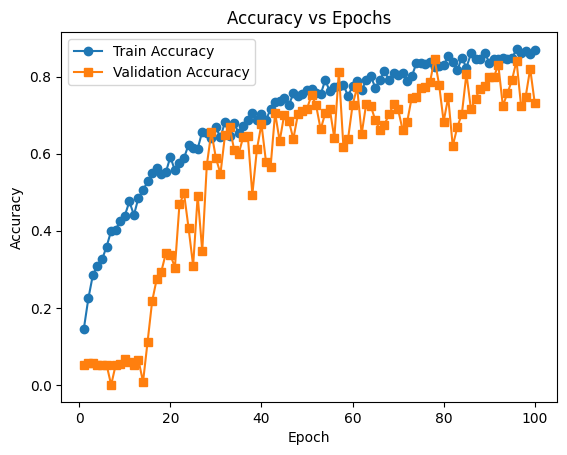

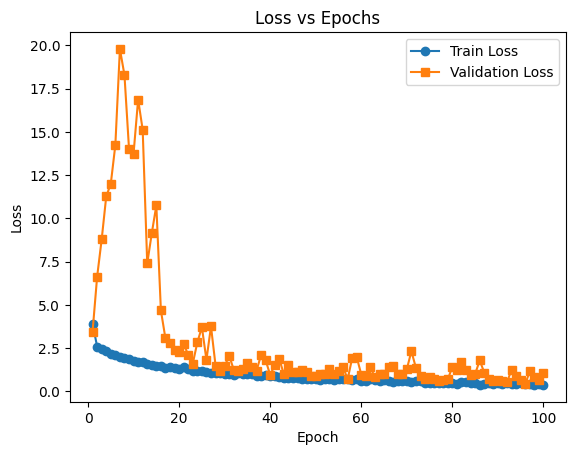

In [11]:
# Save training and validation metrics to an Excel file
df_metrics = pd.DataFrame(
    {
        "Epoch": np.arange(1, epochs + 1),
        "Train Loss": train_loss_history,
        "Train Accuracy": train_acc_history,
        "Validation Loss": val_loss_history,
        "Validation Accuracy": val_acc_history,
    }
)
df_metrics.to_excel(f"{student_name}-{reg_number}-training_metrics.xlsx", index=False)

# Plot and save Accuracy vs Epochs (Train + Validation)
plt.figure()
plt.plot(np.arange(1, epochs + 1), train_acc_history, marker="o", label="Train Accuracy")
plt.plot(np.arange(1, epochs + 1), val_acc_history, marker="s", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
acc_graph_filename = f"{student_name}-{reg_number}-accuracygraph.jpeg"
plt.savefig(acc_graph_filename)
plt.show()

# Plot and save Loss vs Epochs (Train + Validation)
plt.figure()
plt.plot(np.arange(1, epochs + 1), train_loss_history, marker="o", label="Train Loss")
plt.plot(np.arange(1, epochs + 1), val_loss_history, marker="s", label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
loss_graph_filename = f"{student_name}-{reg_number}-lossgraph.jpeg"
plt.savefig(loss_graph_filename)
plt.show()


In [12]:
# Load the best model from best.keras
best_model = load_model("best_model.keras")

# Recompile with a fresh optimizer
best_model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

# Save it with the desired filename
model_filename = f"{student_name}-{reg_number}-model.h5"
best_model.save(model_filename)

print(f"Best trained model saved as {model_filename}")


# Save total training time to Excel
df_training_time = pd.DataFrame({"Total_Training_Time_sec": [total_training_time]})
df_training_time.to_excel(f"{student_name}-{reg_number}-trainingtime.xlsx", index=False)

Best trained model saved as AkhileshNegi-221AI008-model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
